# Human Emotion Detection

## Installing required packages

In [4]:
!pip install opencv-python
!pip install face_recognition








     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 12.0 MB/s eta 0:00:0000:0100:01

  Preparing metadata (setup.py) ... done





     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 76.9 MB/s eta 0:00:00:00:01

  Preparing metadata (setup.py) ... done







  Created wheel for dlib: filename=dlib-19.24.1-cp37-cp37m-linux_x86_64.whl size=3729620 sha256=6044ac5c934d62fce213b050f86497f5d7e44079d5a86ae2753301673e0bb0ef

  Stored in directory: /root/.cache/pip/wheels/be/28/ef/be877f85f9760adadab2a51707ff31c835be8631e38866bad1


  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=598415e46e271e051a26885fef33b46345c3993a711ebc162202ea3f68b813b7

  Stored in directory: /root/.cache/pip/wheels/65/cf/0a/4f8e7e42906ede15f4cdf00d6a8f451e4785679155ce17368c

Successfully built dlib face-recognition-models






In [1]:
!pip install torch

## Importing required packages and modules 

In [5]:
import numpy as np
import cv2
import face_recognition
import matplotlib.pyplot as plt
import os

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.optim as optim

## Facial Landmarks

In [6]:
#Reading an example image from dataset
image = cv2.imread(r'/kaggle/input/emotion-detection-fer/test/sad/im0.png')

#Converting to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape)

(48, 48, 3)


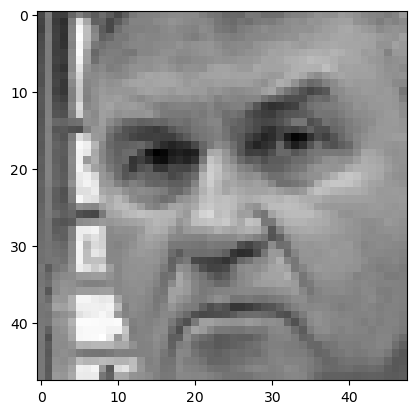

In [7]:
#Plot the image
plt.imshow(gray_image, cmap='gray')

In [8]:
#Extracting landmarks
landmarks = face_recognition.face_landmarks(img1)[0]
print(landmarks)

{'chin': [(8, 21), (8, 26), (9, 31), (10, 35), (11, 40), (13, 44), (16, 47), (19, 48), (24, 48), (29, 48), (35, 47), (41, 45), (45, 41), (47, 35), (48, 29), (48, 23), (47, 16)], 'left_eyebrow': [(9, 17), (10, 14), (13, 13), (16, 14), (19, 14)], 'right_eyebrow': [(26, 13), (29, 11), (33, 9), (37, 9), (40, 12)], 'nose_bridge': [(22, 18), (22, 22), (21, 25), (21, 28)], 'nose_tip': [(18, 32), (20, 32), (22, 33), (25, 32), (28, 31)], 'left_eye': [(12, 21), (14, 19), (17, 18), (19, 20), (17, 21), (14, 21)], 'right_eye': [(29, 18), (31, 16), (34, 16), (37, 17), (34, 18), (31, 19)], 'top_lip': [(18, 40), (19, 38), (21, 37), (23, 38), (25, 37), (28, 37), (31, 39), (30, 39), (25, 38), (23, 39), (21, 39), (19, 40)], 'bottom_lip': [(31, 39), (29, 40), (26, 41), (24, 42), (22, 42), (20, 41), (18, 40), (19, 40), (21, 40), (23, 40), (26, 39), (30, 39)]}


*From above cell we extracted the facial landmarks for taken image. It is returning us 72 landmarks for chin, right eyebrow, left eyebrow, nose bridge, nose tip, right eye, left eye, top lip and bottom lip. Let's project thenm on the image and see*

In [9]:
#Project the landmarks onto the image
for i, v in landmarks.items():
    print(i,v)
    for j in v:
        cv2.circle(image, j, 0, (0,255,255))
        
#Save the image 
cv2.imwrite('face.jpg', image)

chin [(8, 21), (8, 26), (9, 31), (10, 35), (11, 40), (13, 44), (16, 47), (19, 48), (24, 48), (29, 48), (35, 47), (41, 45), (45, 41), (47, 35), (48, 29), (48, 23), (47, 16)]

left_eyebrow [(9, 17), (10, 14), (13, 13), (16, 14), (19, 14)]

right_eyebrow [(26, 13), (29, 11), (33, 9), (37, 9), (40, 12)]

nose_bridge [(22, 18), (22, 22), (21, 25), (21, 28)]

nose_tip [(18, 32), (20, 32), (22, 33), (25, 32), (28, 31)]

left_eye [(12, 21), (14, 19), (17, 18), (19, 20), (17, 21), (14, 21)]

right_eye [(29, 18), (31, 16), (34, 16), (37, 17), (34, 18), (31, 19)]

top_lip [(18, 40), (19, 38), (21, 37), (23, 38), (25, 37), (28, 37), (31, 39), (30, 39), (25, 38), (23, 39), (21, 39), (19, 40)]

bottom_lip [(31, 39), (29, 40), (26, 41), (24, 42), (22, 42), (20, 41), (18, 40), (19, 40), (21, 40), (23, 40), (26, 39), (30, 39)]


True

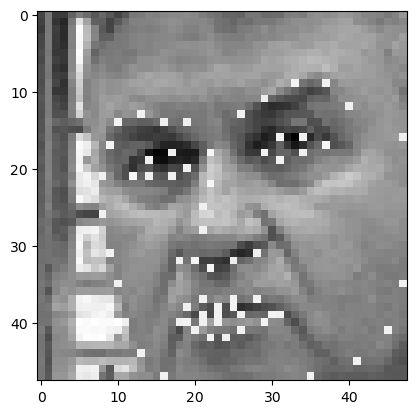

In [10]:
#Let us read the saved image and plot it
output = cv2.imread(r'/kaggle/working/face.jpg')
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2GRAY), cmap='gray')

## Feature Extraction

*Here, in this project, we are approaching the feature extraction problem as follows. Instead of taking flattened out pixel level values of the image, which does not a very good representaion of an image(atleast for this task), we are taking distance from evry landmark to another. By changing facial expressions, the change in distances between the landarks occur. Relying on this principle, the distances were considered features to represent an image.*

In [11]:
#Defining distance measure - Euclidean distance
def distance(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    return ((x1-x2)**2 + (y1-y2)**2)**.5

In [12]:
#Extracting features. 
def features(image_path):
    #Read image from image path and convert to grayscale
    img = cv2.imread(image_path)
    img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #Landmark detection
    landmarks = face_recognition.face_landmarks(img1)
    if len(landmarks) ==0:
        return 0
    else:
        landmarks = landmarks[0]
        points = []
        
        #Adding the landmarks to a list
        for i, v in landmarks.items():
            points.extend(v)
        
        distances = []
        #extracting distances between landmarks and returning them as features
        for i in points:
            distances.extend([distance(i, k) for k in points])
        return distances

In [14]:
#Creating Testing and Training examples of features and targets from the dataset
X_train, X_test, y_train, y_test = ([], [], [], [])

#Extracting directory name and filenames
for dirname, _, filenames in os.walk('/kaggle/input/emotion-detection-fer/'):
    for file in filenames:
        if file.endswith('.png'):
            #label - test/train
            label = dirname.split('/')[-2]
            #target emotion category
            category = dirname.split('/')[-1]
            feat = features(os.path.join(dirname, file))
            
            #creating a new target "can not say" for the images that are not possible to get landmarks from
            if label == 'test':
                X_test.append([0]*5184 if feat == 0 else feat)
                y_test.append('can not say' if feat == 0 else category)
            else:
                X_train.append([0]*5184 if feat == 0 else feat)
                y_train.append('can not say' if feat == 0 else category)

In [15]:
#No.of testing exaples
len(X_test)

7178

In [16]:
#no.of training examples
len(X_train)

28709

In [17]:
#Unique target classes
categories = list(set(y_test))
print(categories)

['neutral', 'disgusted', 'fearful', 'surprised', 'happy', 'sad', 'angry', 'can not say']


In [18]:
#Labeling each category with a discrete value
def labeling(x):
    for i in range(len(x)):
        x[i] = categories.index(x[i])
    return np.array(x)

In [19]:
#Converting our training examples to input format of scikit-learn modules(numpy arrays)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = labeling(y_train)
y_test = labeling(y_test)

In [20]:
#Saving the data as numpy files
np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)

## Classification using ML algorithms

In [17]:
#Defining and fit k Nearest neighbours with k = 15 (default)
knn = KNeighborsClassifier(n_neighbors = 15)
knn.fit(X_train, y_train)

#Prediction and performance metrics
y_pred = knn.predict(X_test)
print(confusion_matrix(y_test, y_pred), '\n', classification_report(y_test, y_pred))

[[1161   36   32   19    0  117   17    0]

 [  68  351   42   21    4   98   14    0]

 [ 100   96  109   62    1  231   46    0]

 [ 149   42   45  160    4  210   38    0]

 [  22    4    9   11   10   26    3    0]

 [  98   33   38   58    1  643   58    0]

 [ 126   28   58   70    2  306   76    0]

 [   0    0    0    0    0    0    0 2225]] 

               precision    recall  f1-score   support



           0       0.67      0.84      0.75      1382

           1       0.59      0.59      0.59       598

           2       0.33      0.17      0.22       645

           3       0.40      0.25      0.31       648

           4       0.45      0.12      0.19        85

           5       0.39      0.69      0.50       929

           6       0.30      0.11      0.17       666

           7       1.00      1.00      1.00      2225



    accuracy                           0.66      7178

   macro avg       0.52      0.47      0.47      7178

weighted avg       0.64      0.66   

In [18]:
#Defining Decision tree and fit to training data
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

#Predictions and performance metrics
y_pred = dt.predict(X_test)
print(confusion_matrix(y_test, y_pred), '\n', classification_report(y_test, y_pred))

[[ 930   60   99   83   12  116   82    0]

 [  38  388   55   35    5   43   34    0]

 [  76   77  196   86   16  115   79    0]

 [  88   47  100  210   11   96   96    0]

 [   8    3    9    8   32    9   16    0]

 [  99   51  117  119   10  372  161    0]

 [  91   39   82  110   11  168  165    0]

 [   0    0    0    0    0    0    0 2225]] 

               precision    recall  f1-score   support



           0       0.70      0.67      0.69      1382

           1       0.58      0.65      0.61       598

           2       0.30      0.30      0.30       645

           3       0.32      0.32      0.32       648

           4       0.33      0.38      0.35        85

           5       0.40      0.40      0.40       929

           6       0.26      0.25      0.25       666

           7       1.00      1.00      1.00      2225



    accuracy                           0.63      7178

   macro avg       0.49      0.50      0.49      7178

weighted avg       0.63      0.63   

## Classification using Feed Forward Neural Networks - ANN

In [3]:
#Checking if whether GPU is available and assigning available device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
#Formatting the data into tensors
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)

In [11]:
#Defining a feed forward neural network - ANN
model = nn.Sequential(nn.Linear(5184, 500), #input layer = 5184
                      nn.ReLU(),
                      nn.Linear(500,100), #hidden layer 1 = 500, #hidden layer 2 = 100
                      nn.ReLU(), 
                      nn.Linear(100, 8), #output layer = 8(no.of classes)
                      nn.Softmax(dim=1)).to(device)
print(model)

Sequential(

  (0): Linear(in_features=5184, out_features=500, bias=True)

  (1): ReLU()

  (2): Linear(in_features=500, out_features=100, bias=True)

  (3): ReLU()

  (4): Linear(in_features=100, out_features=8, bias=True)

  (5): Softmax(dim=1)

)


In [12]:
#For unbalanced dataset, defining class weights
class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = y_train)

In [13]:
#Defining loss function
loss_fn = nn.CrossEntropyLoss(weight = torch.FloatTensor(class_weights)).to(device)

#Optimizer (Stochastic gradient Descent here)
sgd = optim.SGD(model.parameters(), lr = 0.01)

#Training ANN
epochs = 10000
for epoch in range(epochs):
    output = model(X_train_tensor)
    cost = loss_fn(output, y_train_tensor)
    #Setting gradients to 0
    sgd.zero_grad()
    #Back Propagation
    cost.backward()
    sgd.step()
    #Printing training loss for 1000 epochs each
    if epoch % (epochs/10) == 0:
        print('Epoch ' + str(epoch) + ' is completed. Training loss is ' + str(cost))
    elif epoch == epochs-1:
        print('Training is completed. Final raining loss is ' + str(cost))

Epoch 0 is completed. Training loss is tensor(2.1166, device='cuda:0', grad_fn=<NllLossBackward0>)

Epoch 1000 is completed. Training loss is tensor(1.9408, device='cuda:0', grad_fn=<NllLossBackward0>)

Epoch 2000 is completed. Training loss is tensor(1.9119, device='cuda:0', grad_fn=<NllLossBackward0>)

Epoch 3000 is completed. Training loss is tensor(1.8723, device='cuda:0', grad_fn=<NllLossBackward0>)

Epoch 4000 is completed. Training loss is tensor(1.8436, device='cuda:0', grad_fn=<NllLossBackward0>)

Epoch 5000 is completed. Training loss is tensor(1.8245, device='cuda:0', grad_fn=<NllLossBackward0>)

Epoch 6000 is completed. Training loss is tensor(1.7956, device='cuda:0', grad_fn=<NllLossBackward0>)

Epoch 7000 is completed. Training loss is tensor(1.7781, device='cuda:0', grad_fn=<NllLossBackward0>)

Epoch 8000 is completed. Training loss is tensor(1.7447, device='cuda:0', grad_fn=<NllLossBackward0>)

Epoch 9000 is completed. Training loss is tensor(1.7278, device='cuda:0', gr

In [5]:
#Formatting testing data into torch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

In [15]:
#Model testing and evaluation
with torch.no_grad():
    y_pred = model(X_test_tensor) #predicted logits
    predictions = y_pred.argmax(dim = 1) #taking class with maximum probability
print(predictions)

tensor([1, 3, 5,  ..., 4, 4, 3], device='cuda:0')


In [17]:
#A visualisation of predictions
predictions[3000:3050]

tensor([0, 5, 6, 5, 3, 0, 0, 3, 0, 0, 5, 7, 7, 7, 0, 7, 5, 1, 3, 3, 0, 7, 7, 6,
        6, 5, 0, 1, 0, 7, 7, 0, 7, 3, 0, 0, 1, 7, 1, 3, 3, 1, 0, 7, 0, 7, 6, 0,
        6, 1], device='cuda:0')

In [18]:
#Model performance
print(classification_report(predictions.cpu(), y_test_tensor.cpu()))

              precision    recall  f1-score   support



           0       0.39      0.51      0.44       722

           1       0.61      0.08      0.13       691

           2       0.00      0.00      0.00         0

           3       0.79      0.47      0.59       996

           4       0.69      0.85      0.76      1119

           5       0.26      0.33      0.29       525

           6       0.49      0.35      0.41       900

           7       1.00      1.00      1.00      2225



    accuracy                           0.63      7178

   macro avg       0.53      0.45      0.45      7178

weighted avg       0.71      0.63      0.64      7178




/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))


### Using Deep FFNN

In [7]:
model = nn.Sequential(nn.Linear(len(X_train_tensor[0]), 512), 
                      nn.ReLU(),
                      nn.Linear(512,512), 
                      nn.ReLU(), 
                      nn.Linear(512,512), 
                      nn.ReLU(),
                      nn.Linear(512,512), 
                      nn.ReLU(),
                      nn.Linear(512, 8), 
                      nn.Softmax(dim=1)).to(device)
print(model)

class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = y_train)

loss = nn.CrossEntropyLoss(weight = torch.FloatTensor(class_weights)).to(device)
sgd = optim.Adam(model.parameters(), lr = 0.0001)
epochs = 100
for epoch in range(epochs):
    output = model(X_train_tensor)
    cost = loss(output, y_train_tenor)
    sgd.zero_grad()
    cost.backward()
    sgd.step()
    if epoch % (epochs/10) == 0:
        print('Epoch ' + str(epoch) + ' is completed. Training loss is ' + str(cost))
    elif epoch == epochs-1:
        print('Training is completed. Final raining loss is ' + str(cost))
        
with torch.no_grad():
    y_pred = model(X_test_tensor)
    predictions = y_pred.argmax(dim = 1)
print(classification_report(y_test_tensor.cpu(), predictions.cpu()))

#Saving the model
torch.save(model, 'model_deep.pth')

Sequential(

  (0): Linear(in_features=5184, out_features=512, bias=True)

  (1): ReLU()

  (2): Linear(in_features=512, out_features=512, bias=True)

  (3): ReLU()

  (4): Linear(in_features=512, out_features=512, bias=True)

  (5): ReLU()

  (6): Linear(in_features=512, out_features=512, bias=True)

  (7): ReLU()

  (8): Linear(in_features=512, out_features=8, bias=True)

  (9): Softmax(dim=1)

)

Epoch 0 is completed. Training loss is tensor(2.0818, device='cuda:0', grad_fn=<NllLossBackward0>)

Epoch 10 is completed. Training loss is tensor(2.0483, device='cuda:0', grad_fn=<NllLossBackward0>)

Epoch 20 is completed. Training loss is tensor(2.0292, device='cuda:0', grad_fn=<NllLossBackward0>)

Epoch 30 is completed. Training loss is tensor(1.9996, device='cuda:0', grad_fn=<NllLossBackward0>)

Epoch 40 is completed. Training loss is tensor(1.9691, device='cuda:0', grad_fn=<NllLossBackward0>)

Epoch 50 is completed. Training loss is tensor(1.9483, device='cuda:0', grad_fn=<NllLossBackw

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))


## Dimensionality reduction

In [2]:
#Before performing dimensionality reduction, scaling and normalization of data
scaler = MinMaxScaler()
#Fit and transform training data
X_train_scaled = scaler.fit_transform(X_train)
#Normalizing test data about training data
X_test_scaled = scaler.transform(X_test)
X_train_scaled[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [3]:
#Dimensionality reduction - Principal component analysis retaining 99% of variance
pca = PCA(n_components = 0.99)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [6]:
#Dimensions of training data after PCA
X_train_pca.shape

(28709, 9)

### Classification on reduced data

### ML Algorithms

In [8]:
#Training kNN with reduced data
knn = KNeighborsClassifier(15)
knn.fit(X_train_pca, y_train)

#Predictions and model performance
y_pred = knn.predict(X_test_pca)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support



           0       0.39      0.71      0.50       929

           1       0.40      0.14      0.21        85

           2       0.31      0.17      0.22       645

           3       0.65      0.59      0.62       598

           4       0.70      0.81      0.75      1382

           5       0.30      0.15      0.20       666

           6       0.42      0.24      0.30       648

           7       1.00      1.00      1.00      2225



    accuracy                           0.66      7178

   macro avg       0.52      0.48      0.48      7178

weighted avg       0.65      0.66      0.64      7178




In [9]:
#Training Decision tree with reduced data
dt = DecisionTreeClassifier()
dt.fit(X_train_pca, y_train)

#Prediction and performance evaluation
y_pred = dt.predict(X_test_pca)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support



           0       0.38      0.40      0.39       929

           1       0.34      0.38      0.36        85

           2       0.30      0.28      0.29       645

           3       0.58      0.64      0.61       598

           4       0.72      0.68      0.70      1382

           5       0.24      0.22      0.23       666

           6       0.31      0.34      0.33       648

           7       1.00      1.00      1.00      2225



    accuracy                           0.63      7178

   macro avg       0.48      0.49      0.49      7178

weighted avg       0.63      0.63      0.63      7178




In [4]:
#Training Support Vector Classifier on reduced data
svc = SVC()
svc.fit(X_train_pca, y_train)

#Predictions and performance evaluation
y_pred = svc.predict(X_test_pca)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support



           0       0.37      0.81      0.51       929

           1       0.00      0.00      0.00        85

           2       0.35      0.06      0.10       645

           3       0.63      0.60      0.62       598

           4       0.70      0.85      0.77      1382

           5       0.32      0.05      0.09       666

           6       0.42      0.32      0.36       648

           7       1.00      1.00      1.00      2225



    accuracy                           0.67      7178

   macro avg       0.47      0.46      0.43      7178

weighted avg       0.65      0.67      0.62      7178




/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
#Training Random Forest (ensemble method)
rf = RandomForestClassifier(criterion = 'entropy')
rf.fit(X_train_pca, y_train)

#Predictions and performance evaluation
y_pred = rf.predict(X_test_pca)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support



           0       0.43      0.67      0.52       929

           1       1.00      0.32      0.48        85

           2       0.52      0.26      0.34       645

           3       0.68      0.73      0.70       598

           4       0.73      0.83      0.77      1382

           5       0.38      0.21      0.27       666

           6       0.47      0.41      0.44       648

           7       1.00      1.00      1.00      2225



    accuracy                           0.70      7178

   macro avg       0.65      0.55      0.57      7178

weighted avg       0.70      0.70      0.69      7178




### Using ANN

In [19]:
X_train_pca_tensor = torch.FloatTensor(X_train_pca).to(device)

model = nn.Sequential(nn.Linear(len(X_train_pca_tensor[0]), 20), 
                      nn.ReLU(),
                      nn.Linear(20,15), 
                      nn.ReLU(), 
                      nn.Linear(15, 8), 
                      nn.Softmax(dim=1)).to(device)
print(model)

class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = y_train)

loss = nn.CrossEntropyLoss(weight = torch.FloatTensor(class_weights)).to(device)

#Stochastic gradient descent
sgd = optim.SGD(model.parameters(), lr = 0.01)
epochs = 10000
for epoch in range(epochs):
    output = model(X_train_pca_tensor)
    cost = loss(output, y_train_tensor)
    sgd.zero_grad()
    cost.backward()
    sgd.step()
    if epoch % (epochs/10) == 0:
        print('Epoch ' + str(epoch) + ' is completed. Training loss is ' + str(cost))
    elif epoch == epochs-1:
        print('Training is completed. Final raining loss is ' + str(cost))
        
X_test_pca_tensor = torch.tensor(X_test_pca, dtype=torch.float32).to(device)

with torch.no_grad():
    y_pred = model(X_test_pca_tensor)
    predictions = y_pred.argmax(dim = 1)
print(classification_report(y_test_tensor.cpu(), predictions.cpu()))

torch.save(model, 'model_pca.pth')

Sequential(

  (0): Linear(in_features=9, out_features=20, bias=True)

  (1): ReLU()

  (2): Linear(in_features=20, out_features=15, bias=True)

  (3): ReLU()

  (4): Linear(in_features=15, out_features=8, bias=True)

  (5): Softmax(dim=1)

)

Epoch 0 is completed. Training loss is tensor(2.0745, device='cuda:0', grad_fn=<NllLossBackward0>)

Epoch 1000 is completed. Training loss is tensor(1.9574, device='cuda:0', grad_fn=<NllLossBackward0>)

Epoch 2000 is completed. Training loss is tensor(1.9322, device='cuda:0', grad_fn=<NllLossBackward0>)

Epoch 3000 is completed. Training loss is tensor(1.8856, device='cuda:0', grad_fn=<NllLossBackward0>)

Epoch 4000 is completed. Training loss is tensor(1.8620, device='cuda:0', grad_fn=<NllLossBackward0>)

Epoch 5000 is completed. Training loss is tensor(1.8504, device='cuda:0', grad_fn=<NllLossBackward0>)

Epoch 6000 is completed. Training loss is tensor(1.8421, device='cuda:0', grad_fn=<NllLossBackward0>)

Epoch 7000 is completed. Training loss

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
model = nn.Sequential(nn.Linear(len(X_train_pca_tensor[0]), 20), 
                      nn.ReLU(),
                      nn.Linear(20,15), 
                      nn.ReLU(), 
                      nn.Linear(15, 8), 
                      nn.Softmax(dim=1)).to(device)
print(model)

class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = y_train)

loss = nn.CrossEntropyLoss(weight = torch.FloatTensor(class_weights)).to(device)

#Adam Optimizer
sgd = optim.Adam(model.parameters(), lr = 0.01)
epochs = 10000
for epoch in range(epochs):
    output = model(X_train_pca_tensor)
    cost = loss(output, y_train_tensor)
    sgd.zero_grad()
    cost.backward()
    sgd.step()
    if epoch % (epochs/10) == 0:
        print('Epoch ' + str(epoch) + ' is completed. Training loss is ' + str(cost))
    elif epoch == epochs-1:
        print('Training is completed. Final raining loss is ' + str(cost))
        
X_test_pca_tensor = torch.tensor(X_test_pca, dtype=torch.float32).to(device)

with torch.no_grad():
    y_pred = model(X_test_pca_tensor)
    predictions = y_pred.argmax(dim = 1)
print(classification_report(y_test_tensor.cpu(), predictions.cpu()))

torch.save(model, 'model_pca_adam.pth')

Sequential(

  (0): Linear(in_features=9, out_features=20, bias=True)

  (1): ReLU()

  (2): Linear(in_features=20, out_features=15, bias=True)

  (3): ReLU()

  (4): Linear(in_features=15, out_features=8, bias=True)

  (5): Softmax(dim=1)

)

Epoch 0 is completed. Training loss is tensor(2.1004, device='cuda:0', grad_fn=<NllLossBackward0>)

Epoch 1000 is completed. Training loss is tensor(1.7256, device='cuda:0', grad_fn=<NllLossBackward0>)

Epoch 2000 is completed. Training loss is tensor(1.7184, device='cuda:0', grad_fn=<NllLossBackward0>)

Epoch 3000 is completed. Training loss is tensor(1.7162, device='cuda:0', grad_fn=<NllLossBackward0>)

Epoch 4000 is completed. Training loss is tensor(1.7153, device='cuda:0', grad_fn=<NllLossBackward0>)

Epoch 5000 is completed. Training loss is tensor(1.7144, device='cuda:0', grad_fn=<NllLossBackward0>)

Epoch 6000 is completed. Training loss is tensor(1.7138, device='cuda:0', grad_fn=<NllLossBackward0>)

Epoch 7000 is completed. Training loss

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))
